**Introduction**

Customer Churn impacts the cost to the business. Higher Customer Churn leads to loss in revenue and the additional marketing costs involved with replacing those customers with new ones.
So, for a business it would be good if one could predict who is going to get churned so that they can proactively go to the customer and help them in providing better services to those customer and enhance business by changing the customer decision.

This dataset consist of 6650 customers data. It consists of their ID,Age,Gender,Income, Balance,Vintage,Transaction Status,Product Holding, Credit Card,Credit Category,Is_Churn.There are total of 11 features. 

We have 23.11% of customers who have churned. It will be little difficult to directly analyse from the data. We will have to do some preprocessing before modelling to predict on test data with better accuracy.

**Libraries**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA

from sklearn.metrics import confusion_matrix,roc_curve,auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow import keras
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers import Dense,Activation, Embedding,Flatten,LeakyReLU,BatchNormalization
from keras.activations import relu,sigmoid
from keras.layers import Dropout

import imblearn
from imblearn.over_sampling import SMOTE



import warnings
warnings.filterwarnings('ignore')

**DATA LOADING**

In [ ]:
train_data= pd.read_csv("train_PDjVQMB.csv")
test_data= pd.read_csv("test_lTY72QC.csv")

In [ ]:
train_data.shape, test_data.shape

((6650, 11), (2851, 10))

In [ ]:
columns= train_data.columns

**Columns Description**

**ID** : Unique Identifier of a row

**Age**: Age of the customer in years

**Gender**: Gender of the customer (Male and Female)

**Income**: Yearly income of the customer
* Less than 5L
* 5L - 10L 
* 10L - 15L
* More than 15L  

**Balance**:Average quarterly balance of the customer

**Vintage**: No. of years the customer is associated with bank

**Transaction_Status**: Whether the customer has done any transaction in the past 3 months or not.
* 1 means Yes 
* 0 means No

**Product_Holdings**: No. of product holdings with the bank

**Credit_Card**: Whether the customer has a credit card or not
* 1 means Yes 
* 0 means No

**Credit_Category**: Category of a customer based on the credit score
* Poor
* Average
* Good

**Is_Churn**: Whether the customer will churn in next 6 months or not
* 1 means Churned 
* 0 means Not Churned

Categorical Features and Numerical Features

In [ ]:
categorical_feature= train_data.select_dtypes(include= np.object).columns
print("categorical features are : ",end=" ")
print(categorical_feature)

numerical_feature= train_data.select_dtypes(include=[np.int64,np.float64]).columns
print("numerical feature are : ", end=" ")
print(numerical_feature)

categorical features are :  Index(['ID', 'Gender', 'Income', 'Product_Holdings', 'Credit_Category'], dtype='object')
numerical feature are :  Index(['Age', 'Balance', 'Vintage', 'Transaction_Status', 'Credit_Card',
       'Is_Churn'],
      dtype='object')


In [ ]:
train_data['Is_Churn'].value_counts()

0    5113
1    1537
Name: Is_Churn, dtype: int64

**We have highly imbalanced data. We need to do either upsampling or downsampling to balance the data.**

In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6650 entries, 0 to 6649
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID                  6650 non-null   object 
 1   Age                 6650 non-null   int64  
 2   Gender              6650 non-null   object 
 3   Income              6650 non-null   object 
 4   Balance             6650 non-null   float64
 5   Vintage             6650 non-null   int64  
 6   Transaction_Status  6650 non-null   int64  
 7   Product_Holdings    6650 non-null   object 
 8   Credit_Card         6650 non-null   int64  
 9   Credit_Category     6650 non-null   object 
 10  Is_Churn            6650 non-null   int64  
dtypes: float64(1), int64(5), object(5)
memory usage: 571.6+ KB


**We do not have any null values in any feature.**

In [ ]:
train_data.head()

,ID,Age,Gender,Income,Balance,Vintage,Transaction_Status,Product_Holdings,Credit_Card,Credit_Category,Is_Churn
0,84e2fcc9,36,Female,5L - 10L,563266.44,4,0,1,0,Average,1
1,57fea15e,53,Female,Less than 5L,875572.11,2,1,1,1,Poor,0
2,8df34ef3,35,Female,More than 15L,701607.06,2,1,2,0,Poor,0
3,c5c0788b,43,Female,More than 15L,1393922.16,0,1,2,1,Poor,1
4,951d69c4,39,Female,More than 15L,893146.23,1,1,1,1,Good,1


In [ ]:
train_data.drop(['ID','Age'],axis= 'columns',inplace=True)
test_data.drop(columns=['ID','Age'],axis=1,inplace=True) 

**Unique values of Categorical Data**

In [ ]:
def unique_value(df):
  for column in df:
    if df[column].dtypes== 'object':
      print(f'{column} : {df[column].unique()}')

unique_value(train_data)


Gender : ['Female' 'Male']
Income : ['5L - 10L' 'Less than 5L' 'More than 15L' '10L - 15L']
Product_Holdings : ['1' '2' '3+']
Credit_Category : ['Average' 'Poor' 'Good']


**EXPLORATORY DATA ANALYSIS**

In [ ]:
columns

Index(['ID', 'Age', 'Gender', 'Income', 'Balance', 'Vintage',
       'Transaction_Status', 'Product_Holdings', 'Credit_Card',
       'Credit_Category', 'Is_Churn'],
      dtype='object')

In [ ]:
train_data['Gender'].value_counts()

Male      3612
Female    3038
Name: Gender, dtype: int64

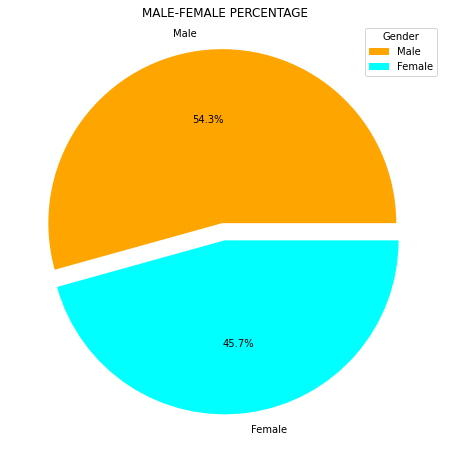

In [ ]:
def calcu_percentage(pct,data):
  return "{:.1f}%".format(pct)

gender_data= dict(train_data['Gender'].value_counts())
fig, ax= plt.subplots(figsize=(10,8))
labels=list(gender_data.keys())
colors=["orange", "cyan"]
explode=(0.1, 0.0)
ax.pie(gender_data.values(), labels=labels, colors=colors,shadow=False, explode=explode,autopct = lambda pct: calcu_percentage(pct,list(gender_data.values())))
ax.legend(labels,
          title="Gender",
          loc ="upper right")
ax.set_title("MALE-FEMALE PERCENTAGE")
plt.show()

This dataset have more samples of Male than Females. But the difference in percentage is not that high, so we can say that the data of gender is almost balanced.

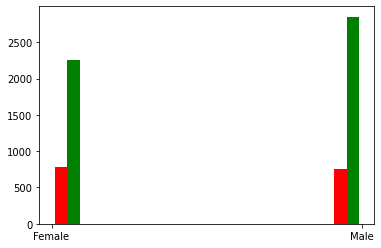

In [ ]:
gender_churn_yes= train_data[train_data.Is_Churn==1].Gender
gender_churn_no= train_data[train_data.Is_Churn==0].Gender

plt.hist([gender_churn_yes,gender_churn_no],color=['Red','Green'])
plt.show()

We have almost equal number of male and female who had churned.But if we talk about the ratio then female ratio would be high in comparison to Male. 

In [ ]:
train_data['Income'].value_counts()

10L - 15L        1885
5L - 10L         1847
Less than 5L     1573
More than 15L    1345
Name: Income, dtype: int64

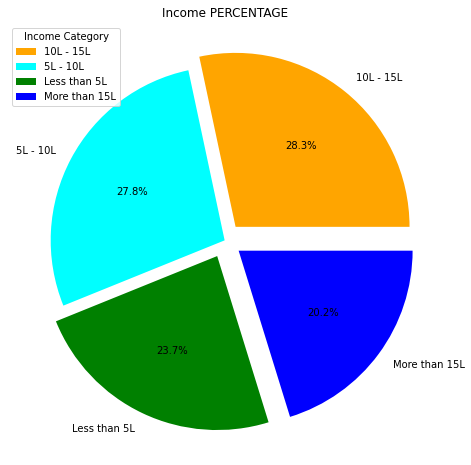

In [ ]:
def calcu_percentage(pct,data):
  return "{:.1f}%".format(pct)

income_data= dict(train_data['Income'].value_counts())
fig, ax= plt.subplots(figsize=(25,8))
labels=list(income_data.keys())
colors=["orange", "cyan", "green","blue"]
explode=(0.1, 0.0, 0.1,0.1)
ax.pie(income_data.values(), labels=labels, colors=colors,shadow=False, explode=explode,autopct = lambda pct: calcu_percentage(pct,list(income_data.values())))
ax.legend(labels,title="Income Category",
          loc ="upper left")
ax.set_title("Income PERCENTAGE")
plt.show()

We have four kind of categories under Income, We have highest set of data of 10-15lac and 5-10lac.The difference in percentage is very less. Then we have 23.7% of data under less than 5lac and followed by more than 15lac.

The difference in percentage is not that signigficant. We can consider the data as uniformly distributed. 

**Analysis of Income with Is_Churn**

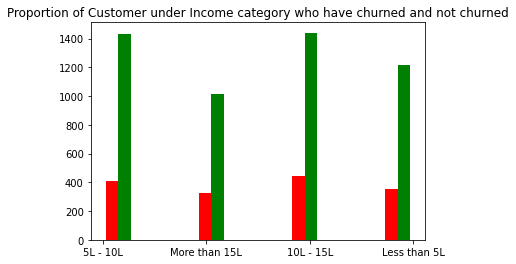

In [ ]:
income_churn_yes= train_data[train_data.Is_Churn==1].Income
income_churn_no= train_data[train_data.Is_Churn==0].Income
plt.hist([income_churn_yes,income_churn_no],color=['Red','Green'])
plt.title("Proportion of Customer under Income category who have churned and not churned")
plt.show()

In [ ]:
train_data['Vintage'].value_counts()

3    1405
1    1354
2    1328
4    1296
0     956
5     311
Name: Vintage, dtype: int64

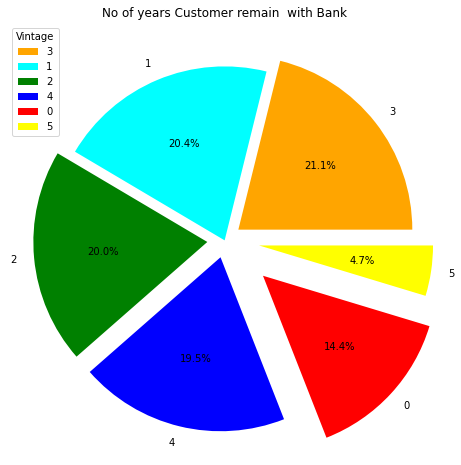

In [ ]:
def calcu_percentage(pct,data):
  return "{:.1f}%".format(pct)

vintage_data= dict(train_data['Vintage'].value_counts())
fig, ax= plt.subplots(figsize=(25,8))
labels=list(vintage_data.keys())
colors=["orange", "cyan", "green","blue","red","yellow"]
explode=(0.1, 0.0, 0.1,0.1,0.3,0.2)
ax.pie(vintage_data.values(), labels=labels, colors=colors,shadow=False, explode=explode,autopct = lambda pct: calcu_percentage(pct,list(vintage_data.values())))
ax.legend(labels,title="Vintage",
          loc ="upper left")
ax.set_title("No of years Customer remain  with Bank")
plt.show()

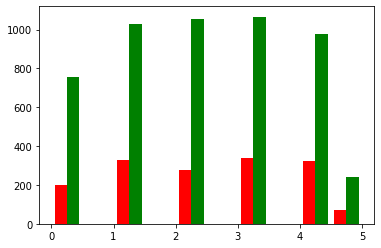

In [ ]:
vintage_churn_yes= train_data[train_data.Is_Churn==1].Vintage
vintage_churn_no= train_data[train_data.Is_Churn==0].Vintage

plt.hist([vintage_churn_yes,vintage_churn_no],color=['Red','Green'])
plt.show()

In [ ]:
train_data['Transaction_Status'].value_counts()

1    3430
0    3220
Name: Transaction_Status, dtype: int64

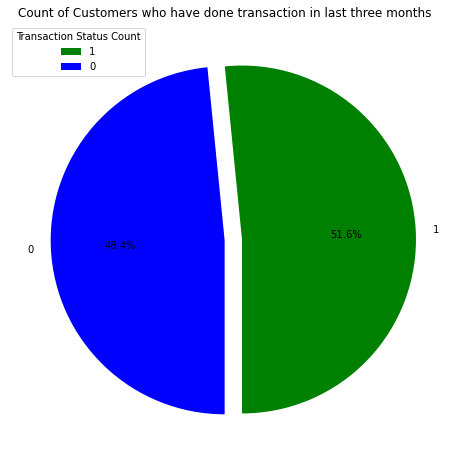

In [ ]:
def calcu_percentage(pct,data):
  return "{:.1f}%".format(pct)

transaction_data= dict(train_data['Transaction_Status'].value_counts())
fig, ax= plt.subplots(figsize=(25,8))
labels=list(transaction_data.keys())
colors=["green","blue"]
explode=(0.1, 0.0)
ax.pie(transaction_data.values(), startangle= -90, labels=labels, colors=colors,shadow=False, explode=explode,autopct = lambda pct: calcu_percentage(pct,list(transaction_data.values())))
ax.legend(labels,title="Transaction Status Count",
          loc ="upper left")
ax.set_title("Count of Customers who have done transaction in last three months")
plt.show()

**We have almost equal number of cutomers who have done transaction and who have not done any transaction in last three months. Data is balanced for this category.**

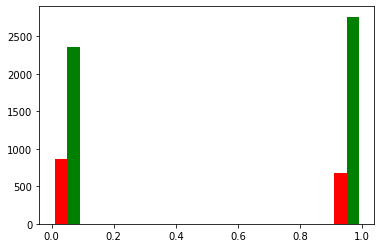

In [ ]:
ts_churn_yes= train_data[train_data.Is_Churn==1].Transaction_Status
ts_churn_no= train_data[train_data.Is_Churn==0].Transaction_Status

plt.hist([ts_churn_yes,ts_churn_no],color=['Red','Green'])
plt.show()

We have slightly higher number of customer who have not done any transaction in last three months and have churned. 

In [ ]:
train_data['Product_Holdings'].value_counts()
test_data['Product_Holdings'].value_counts()

2     1359
1     1342
3+     150
Name: Product_Holdings, dtype: int64

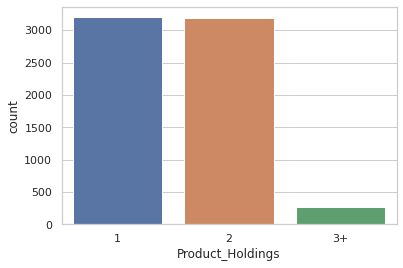

In [ ]:
sns.set_theme(style="whitegrid")
y=sns.countplot(x=train_data['Product_Holdings'],data=train_data)
plt.show()

We have equal samples for the customers who have 1 or 2 holdings but very less samples for customers who have 3+ holdings.

We can merge 3+ with 2 to get better model

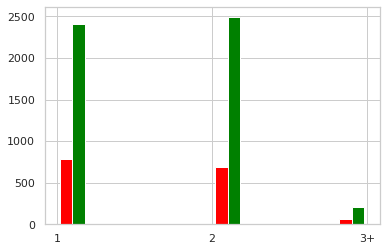

In [ ]:
ph_churn_yes= train_data[train_data.Is_Churn==1].Product_Holdings
ph_churn_no= train_data[train_data.Is_Churn==0].Product_Holdings

plt.hist([ph_churn_yes,ph_churn_no],color=['Red','Green'])
plt.show()

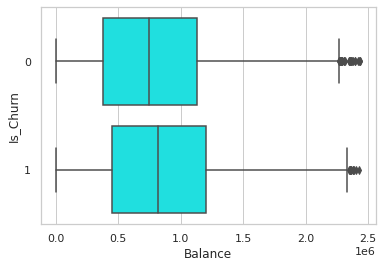

In [ ]:
sns.set_theme(style="whitegrid")
sns.boxplot(x='Balance',y="Is_Churn",data=train_data,orient="h",color="cyan")
plt.show()

In [ ]:
train_data['Credit_Card'].value_counts()

1    4418
0    2232
Name: Credit_Card, dtype: int64

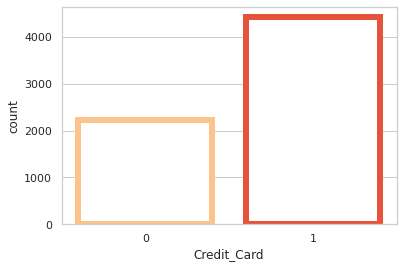

In [ ]:
ax= sns.countplot(x= train_data['Credit_Card'],
                  data=train_data,
                  facecolor=(1,1,1,1),
                  linewidth=6,
                  edgecolor= sns.color_palette('OrRd',2))

We have more samples of customers who have credit card. 

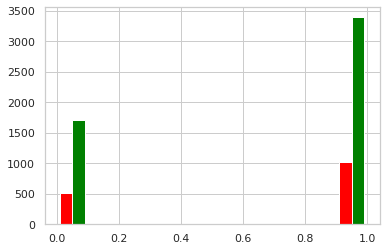

In [ ]:
cc_churn_yes= train_data[train_data.Is_Churn==1].Credit_Card
cc_churn_no= train_data[train_data.Is_Churn==0].Credit_Card


plt.hist([cc_churn_yes,cc_churn_no],color=['Red','Green'])
plt.show()

In [ ]:
train_data['Credit_Category'].value_counts()

Poor       3076
Average    2043
Good       1531
Name: Credit_Category, dtype: int64

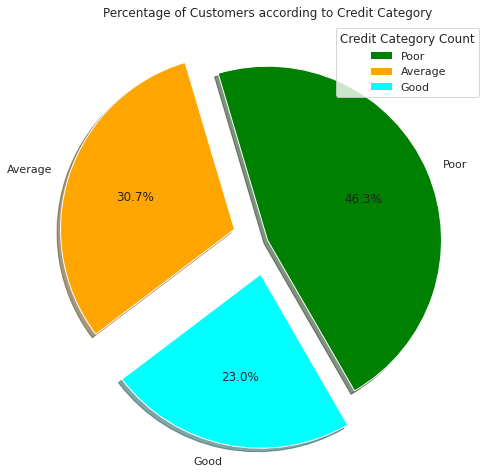

In [ ]:
def calcu_percentage(pct,data):
  return "{:.1f}%".format(pct)

credit_data= dict(train_data['Credit_Category'].value_counts())
fig, ax= plt.subplots(figsize=(25,8))
labels=list(credit_data.keys())
colors=["green","orange","cyan"]
explode=(0.0,0.2,0.2)
ax.pie(credit_data.values(), startangle=-60,labels=labels, colors=colors,shadow=True, explode=explode,autopct = lambda pct: calcu_percentage(pct,list(credit_data.values())))
ax.legend(labels,title="Credit Category Count",
          loc ="best")
ax.set_title("Percentage of Customers according to Credit Category")
plt.show()

We have more customers under poor credit category. Almost half of the customers comes under poor credit category.We can consider equal distribution of Average and Good credit category customers. 

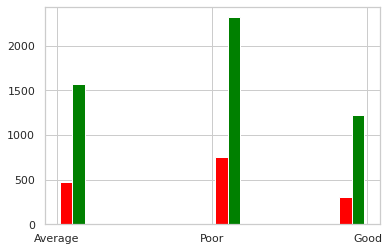

In [ ]:
c_churn_yes= train_data[train_data.Is_Churn==1].Credit_Category
c_churn_no= train_data[train_data.Is_Churn==0].Credit_Category

plt.hist([c_churn_yes,c_churn_no],color=['Red','Green'])
plt.show()

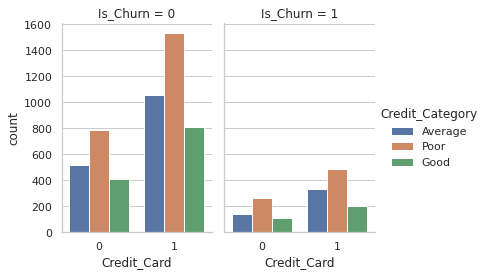

In [ ]:
pt =sns.catplot(x="Credit_Card", hue="Credit_Category",col="Is_Churn",
                data=train_data, kind="count",
                height=4, aspect=.7)

**Converting Categorical Feature into Numerical Feature Using One Hot Encoding**

Replacing the category of 3+ to 2. As we have very less samples under 3+ category and it will be dificult to make any analysis from that category.It can make the model overfit.

In [ ]:
train_data['Product_Holdings'].replace('3+','2',inplace= True)
test_data['Product_Holdings'].replace('3+','2',inplace= True)

In [ ]:
print(train_data['Product_Holdings'].value_counts())
print(test_data['Product_Holdings'].value_counts())

2    3450
1    3200
Name: Product_Holdings, dtype: int64
2    1509
1    1342
Name: Product_Holdings, dtype: int64


In [ ]:
train_data= pd.get_dummies(data=train_data,columns=['Gender','Income','Product_Holdings','Credit_Category'])
test_data= pd.get_dummies(data=test_data,columns=['Gender','Income','Product_Holdings','Credit_Category'])

**Normalizing the numerical feature.**

Normalization : Normalization is a process to rescale the value of feature in a range of [0,1].
Internally, it uses the formula: 
> *Xi- Xmin/Xmax-Xmin*



In [ ]:
num_feature= ['Balance','Vintage']

for i in num_feature:
  scaler= MinMaxScaler()
  train_data[i]= scaler.fit_transform(train_data[i].values.reshape(-1,1))
  test_data[i]= scaler.transform(test_data[i].values.reshape(-1,1))


train_data['Balance']= np.round(train_data['Balance'],2)
test_data['Balance']= np.round(test_data['Balance'],2)


In [ ]:
train_data.head()

,Balance,Vintage,Transaction_Status,Credit_Card,Is_Churn,Gender_Female,Gender_Male,Income_10L - 15L,Income_5L - 10L,Income_Less than 5L,Income_More than 15L,Product_Holdings_1,Product_Holdings_2,Credit_Category_Average,Credit_Category_Good,Credit_Category_Poor
0,0.23,0.8,0,0,1,1,0,0,1,0,0,1,0,1,0,0
1,0.36,0.4,1,1,0,1,0,0,0,1,0,1,0,0,0,1
2,0.29,0.4,1,0,0,1,0,0,0,0,1,0,1,0,0,1
3,0.57,0.0,1,1,1,1,0,0,0,0,1,0,1,0,0,1
4,0.37,0.2,1,1,1,1,0,0,0,0,1,1,0,0,1,0


In [ ]:
test_data.head()

,Balance,Vintage,Transaction_Status,Credit_Card,Gender_Female,Gender_Male,Income_10L - 15L,Income_5L - 10L,Income_Less than 5L,Income_More than 15L,Product_Holdings_1,Product_Holdings_2,Credit_Category_Average,Credit_Category_Good,Credit_Category_Poor
0,0.41,0.4,1,1,1,0,0,0,0,1,0,1,1,0,0
1,0.14,0.4,0,1,0,1,0,1,0,0,0,1,1,0,0
2,0.18,0.0,0,1,1,0,1,0,0,0,0,1,0,1,0
3,0.01,0.0,1,1,0,1,0,0,1,0,0,1,0,0,1
4,0.45,0.4,1,0,0,1,0,0,0,1,0,1,0,1,0


**Spliting the features and class**

In [ ]:
X_train= train_data.drop(columns=['Is_Churn'],axis=1)
Y_train= train_data['Is_Churn']

**DATA UPSAMPLING USING SMOTE**

In [ ]:
oversample = SMOTE()
X, y = oversample.fit_resample(X_train, Y_train)

In [ ]:
X.shape,y.shape

((10226, 15), (10226,))

In [ ]:
y.value_counts()

1    5113
0    5113
Name: Is_Churn, dtype: int64

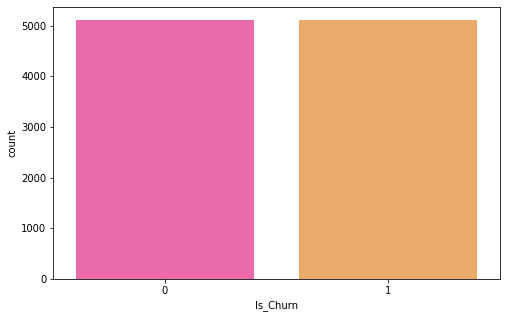

In [ ]:
plt.figure(figsize=(8,5))
sns.countplot(y,palette='spring')
plt.show()

Now we have equal count of both the class 0 and 1. We are good to go for modelling.

**PCA**

In [ ]:
n_com= 2
pca_model= PCA(n_components=n_com)
pca_matrix_train= pca_model.fit_transform(X)
pca_matrix_test= pca_model.transform(test_data)

In [ ]:
train_with_pca= pd.concat([X,pd.DataFrame(pca_matrix_train,columns=['PC-{}'.format(i) for i in range(0,n_com)])],axis=1)
test_with_pca= pd.concat([test_data,pd.DataFrame(pca_matrix_test,columns=['PC-{}'.format(i) for i in range(0,n_com)])],axis=1)

In [ ]:
x_new= train_with_pca
y_new= y

In [ ]:
x_new.shape,y_new.shape

((10226, 17), (10226,))

**Cross_Validation and Hyper Parameter Tuning**

In [ ]:
#"max_depth":[5,10,15,20,25,30],
classifier= RandomForestClassifier()
param= {"n_estimators":[50,100,150,200],
        "max_features": ["auto","sqrt","log2"],
        "class_weight": ["balanced","balanced_subsample"],
        "max_samples":[0.2,0.4,0.6,0.8,1.0]    
}
gsv= GridSearchCV(estimator=classifier,param_grid= param, cv=5 , n_jobs=-1)
gsv.fit(x_new,y_new)

GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'class_weight': ['balanced', 'balanced_subsample'],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'max_samples': [0.2, 0.4, 0.6, 0.8, 1.0],
                         'n_estimators': [50, 100, 150, 200]})

In [ ]:
print(gsv.best_params_)
print(gsv.best_score_)

{'class_weight': 'balanced_subsample', 'max_features': 'sqrt', 'max_samples': 0.4, 'n_estimators': 200}
0.7393022583274181



**Modelling**

In [ ]:
model= RandomForestClassifier(n_estimators=200,max_samples=0.4,random_state=2,max_features='sqrt',class_weight='balanced_subsample')
model.fit(x_new,y_new)

RandomForestClassifier(class_weight='balanced_subsample', max_features='sqrt',
                       max_samples=0.4, n_estimators=200, random_state=2)

**Evaluation**

In [ ]:
y_pred_train= model.predict_proba(x_new)
y_predict=[]
for i in y_pred_train:
  y_predict.append(i[1])

In [ ]:
precision,recall,thresholds = precision_recall_curve(y_new,y_predict)
fscore= (2*precision*recall)/(precision+recall)
index= np.argmax(fscore)
print("index : " + str(index))
threshold_value= np.round(thresholds[index],2)
print("threshold_value : " + str(threshold_value))

pred_y=[]
for i in y_predict:
  if i>=threshold_value:
    pred_y.append(1)
  else:
    pred_y.append(0)

f1score_train= f1_score(y_new, pred_y,average='macro')
print("f1score_train : " + str(f1score_train))

index : 711
threshold_value : 0.5
f1score_train : 0.9451387772468167


In [ ]:
print(classification_report(y_new,pred_y))

              precision    recall  f1-score   support

           0       0.95      0.94      0.94      5113
           1       0.94      0.95      0.95      5113

    accuracy                           0.95     10226
   macro avg       0.95      0.95      0.95     10226
weighted avg       0.95      0.95      0.95     10226



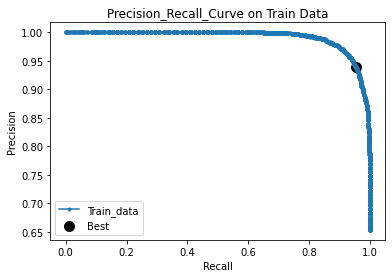

In [ ]:
plt.plot(recall,precision, marker='.',label='Train_data')
plt.scatter(x=recall[index],y=precision[index], marker='o', color='black',linewidths=5, label='Best')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision_Recall_Curve on Train Data")
plt.legend(loc='lower left')
plt.show()

In [ ]:
matrix= confusion_matrix(y_new,pred_y)
print(matrix)

[[4810  303]
 [ 258 4855]]


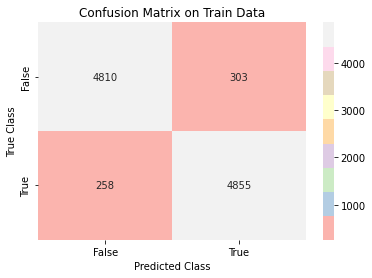

In [ ]:
axis= plt.subplot()
sns.heatmap(matrix,fmt='d',annot=True,cmap='Pastel1',ax=axis)
axis.set_title("Confusion Matrix on Train Data")
axis.set_xlabel("Predicted Class")
axis.set_ylabel("True Class")
axis.set_xticklabels(["False","True"])
axis.set_yticklabels(["False","True"])
plt.show()

In [ ]:
test_predictions = model.predict_proba(test_with_pca)
y_predict_test=[]
for i in test_predictions:
  y_predict_test.append(i[1])
y_test=[]
for i in y_predict_test:
  if i>=threshold_value:
    y_test.append(1)
  else:
    y_test.append(0)

In [ ]:
submission = pd.read_csv('sample_OoSmYo5.csv')
submission['Is_Churn'] = y_test
submission.to_csv('final_submission.csv', index=False)